In [1]:
%%bash
DATA_DIR=/tmp/asd-diagnosis

if [ ! -d $DATA_DIR ]; then
  mkdir -p $DATA_DIR
fi

wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/Harmonized_structural_features.csv -O $DATA_DIR/Harmonized_structural_features.csv &> .log
wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/Harmonized_functional_features.csv -O $DATA_DIR/Harmonized_functional_features.csv &> .log
wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/dict.csv -O $DATA_DIR/dict.csv &> .log

ls -lrth $DATA_DIR/*

-rw-r--r-- 1 root root  763 Nov 14 10:10 /tmp/asd-diagnosis/dict.csv
-rw-r--r-- 1 root root 417K Nov 14 10:10 /tmp/asd-diagnosis/functional_features.csv
-rw-r--r-- 1 root root 5.5M Nov 14 10:10 /tmp/asd-diagnosis/Harmonized_structural_features.csv
-rw-r--r-- 1 root root 133M Nov 14 10:12 /tmp/asd-diagnosis/Harmonized_functional_features.csv


In [2]:
import logging, os
logging.disable(logging.WARNING)
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Autism Spectrum Disorders (ASD) diagnosis combining structural and functional Magnetic Resonance Imaging and Radiomics¶

For an introduction to Autism Spectrum Disorders (ASD) and to the dataset of this ML example please refer to the [first notebook](sMRI_fMRI_sep.ipynb). In that notebook structural and functional MRI features datasets were used separately. While here we are going to combine those datasets and evaluate if the ML model predictions have improved. 

# Import dataframe and normalize with RobustScaler: DF_normalized
Pre-processing is the same as the first notebook.

In [3]:
import pandas as pd

path_to_data = '/tmp/asd-diagnosis/'

DF_struct = pd.read_csv(os.path.join(path_to_data,'Harmonized_structural_features.csv'))
DF_funct  = pd.read_csv(os.path.join(path_to_data,'Harmonized_functional_features.csv'))

In [4]:
DF_struct = DF_struct.set_index('FILE_ID')
DF_funct = DF_funct.set_index('FILE_ID')
DF_funct= DF_funct.drop(['SITE', 'Database_Abide', 'AGE_AT_SCAN', 'DX_GROUP'], axis =1)
DF_merge = DF_struct.join(DF_funct,how='inner')
DF_merge = DF_merge.reset_index()
DF_merge.loc[DF_merge.DX_GROUP == -1, 'DX_GROUP'] = 0
DF_merge

,FILE_ID,Database_Abide,SITE,AGE_AT_SCAN,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,51457,1.0,CALTECH,22.9,1,4688.148643,2.930110,0.587509,8800.363280,2.325779,...,-2.705760,-4.941687,-0.313784,-1.580897,-0.578138,0.800900,1.147299,-0.890745,4.318482,1.020236
1,51458,1.0,CALTECH,39.2,1,3984.677523,2.882359,0.460643,6547.377947,2.435749,...,-1.542383,-2.030129,0.686534,-3.049052,1.500650,-0.057321,-0.400296,0.395253,3.167437,-0.097813
2,51459,1.0,CALTECH,22.8,1,4784.864858,2.737028,0.637104,9181.350601,2.683773,...,3.010815,1.032087,-0.068159,-3.309840,-0.691436,-0.463286,-1.549897,0.358268,1.696029,-1.191784
3,51461,1.0,CALTECH,37.7,1,2139.453979,2.286036,0.518532,6268.548302,2.528375,...,2.469967,2.228592,-1.300355,1.016235,0.685534,-1.513635,0.778284,1.085581,-2.308573,-2.923374
4,51464,1.0,CALTECH,20.9,1,6194.078262,2.955411,0.831313,11308.319412,2.380809,...,1.399667,-1.951666,-1.588347,-0.684389,-1.423833,0.770992,-2.364999,3.107560,1.168626,-0.658174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,30244,2.0,U_MIA_A,9.5,0,2760.894710,2.719528,0.645727,8044.910494,2.797142,...,-2.494394,-2.287528,-2.692700,0.572010,-2.051990,-2.813308,-2.631377,-0.497931,5.814645,-1.464597
1379,30249,2.0,U_MIA_A,12.4,0,3978.719928,2.766787,0.606700,7192.725506,2.764371,...,-1.049086,-0.655575,2.143340,-4.697099,-0.670624,0.330856,-0.364826,2.593785,3.250819,1.271162
1380,30250,2.0,U_MIA_A,10.1,0,2954.162825,2.897091,0.770469,8104.601082,2.905285,...,0.638060,3.033216,-0.703276,0.765123,-0.741325,-0.049255,1.498713,-0.294101,9.475724,-0.006066
1381,30252,2.0,U_MIA_A,11.3,0,3276.342103,2.925723,0.678409,7901.169064,2.882859,...,-2.245569,1.083005,-0.479682,-0.084593,2.388419,-1.887193,2.116627,-2.294673,5.933953,0.806741


In [5]:
DF_normalized = DF_merge.drop(['SITE', 'Database_Abide', 'AGE_AT_SCAN', 'FILE_ID'], axis =1)

In [6]:
from sklearn.preprocessing import RobustScaler

RS_instance = RobustScaler()
DF_normalized.iloc[:,1:] = RS_instance.fit_transform(DF_normalized.iloc[:,1:].to_numpy())
DF_normalized

,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,lh_caudalmiddlefrontal_ThickStd,lh_cuneus_GrayVol,lh_cuneus_ThickAvg,lh_cuneus_ThickStd,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,1,1.268638,0.377530,-0.589783,0.326769,-1.746200,0.977805,-0.930078,-0.735032,0.054484,...,-0.557912,-1.667843,0.046921,-0.449884,-0.203291,0.482292,0.457513,-0.164615,-0.233920,0.474908
1,1,0.435023,0.195201,-1.497886,-0.869530,-1.260341,0.149260,-1.395270,-0.014497,-0.708084,...,-0.146633,-0.584021,0.436218,-0.952848,0.509680,0.173098,-0.099725,0.295015,-0.521565,0.056147
2,1,1.383247,-0.359718,-0.234784,0.529067,-0.164543,1.139456,-0.313275,-0.094698,0.732500,...,1.463021,0.555883,0.142512,-1.042189,-0.242149,0.026839,-0.513657,0.281796,-0.889267,-0.353597
3,1,-1.751570,-2.081748,-1.083519,-1.017585,-0.851110,0.637108,-1.274742,-0.708439,-0.928185,...,1.271820,1.001280,-0.337026,0.439847,0.230116,-0.351573,0.324643,0.541746,-1.890011,-1.002159
4,1,3.053168,0.474139,1.155356,1.658454,-1.503074,0.539329,-0.320901,-0.005986,0.303621,...,0.893446,-0.554813,-0.449105,-0.142757,-0.493343,0.471517,-0.807148,1.264425,-1.021064,-0.153735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,-1.015162,-0.426538,-0.173057,-0.074364,0.336335,0.698862,-0.313788,-0.039112,0.038536,...,-0.483189,-0.679837,-0.878889,0.287663,-0.708784,-0.819811,-0.903062,-0.024219,0.139968,-0.455778
1379,0,0.427964,-0.246087,-0.452409,-0.526861,0.191545,-0.374590,0.293213,-0.100998,0.172274,...,0.027758,-0.072346,1.003167,-1.517439,-0.235011,0.312947,-0.086953,1.080796,-0.500728,0.568892
1380,0,-0.786139,0.251453,0.719843,-0.042670,0.814119,0.230835,0.368386,0.695370,0.510382,...,0.624201,1.300800,-0.104659,0.353820,-0.259260,0.176004,0.584045,0.048632,1.054866,0.090510
1381,0,-0.404356,0.360779,0.060875,-0.150689,0.715041,0.046943,0.291748,0.349174,-0.664107,...,-0.395224,0.574837,-0.017642,0.062723,0.814161,-0.486156,0.806535,-0.666395,0.169783,0.394945


# ASD/TD classification using both structural and functional features

First, you have to define the model architecture. To implement a joint fusion approach you have to use as input both structural and functional features to 2 different neural networks.

### HINT: you can copy the networks of the other notebook

Then you have to find a way to merge these two networks.

In [7]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

import logging
tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.regularizers import l1

In [8]:
def structural_model():
    """ This function returns a model ...
    """
    input_data= Input(221,)
    x = Dense(32,  'relu', kernel_initializer='normal', kernel_regularizer=l1(0.01))(input_data)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    return Model(inputs=input_data, outputs=x)


def functional_model():
    """ This function returns a model ...
    """
    input_data= Input(5253,)
    x = Dense(64, 'relu', kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(input_data)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    return Model(inputs=input_data, outputs=x)


def joint_model(model_1, model_2):
    """ This function combines the output of two keras models
    model_1
    model_2

    returns: a new model which combines model_1 and model_2 by adding 3 dense layers
    """
    combined = Concatenate(axis=-1)([model_1.output, model_2.output])
    z = Dense(16, 'relu',  kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(combined)
    z = BatchNormalization()(z)
    z = Dropout(0.2)(z)
    z = Dense(8, 'relu',  kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(z)
    z = BatchNormalization()(z)
    z = Dropout(0.1)(z)
    z = Dense(1, 'sigmoid')(z) #, kernel_regularizer=l1(0.01))(z)
    return Model(inputs=[model_1.input, model_2.input], outputs = z)

## Callback

A callback is an action passed to the model fit function which is performend while training the neural network. These actions allow you to modify certain parameters when a specific condition is met while training. These actions may be implemented before or after an epoch or batch is processed, when training begins or ends and when a specific condition is met. Callbacks can help with tasks like saving the model, reducing learning rates, stopping training early, or logging performance metrics. Here we implement two actions:

* EarlyStopping
* ReduceLROnPlateau

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=10)

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

# Cross-validation setting

In [10]:
import numpy as np

acc = []
AUC = []
shap_values_per_cv_s =[]
shap_values_per_cv_f =[]
var_f = []
var_s = []
np.random.seed(1) # Reproducibility
n_cv = 10 #NUMERO DI KFOLD
rs_=13 
tprs = []
aucs = []
interp_fpr = np.linspace(0, 1, 100)

In [11]:
import time

from tensorflow.keras.optimizers import SGD #stochastic gradient descent
from tensorflow.keras.backend import clear_session

# import sklearn 
from sklearn.model_selection import StratifiedKFold #train_test_split, KFold
from sklearn.metrics import roc_curve, auc

import shap
import matplotlib.pyplot as plt

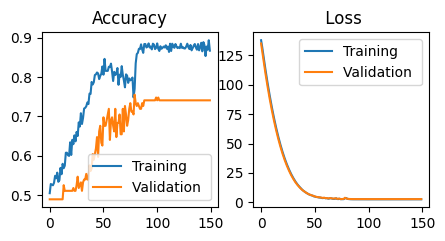

len(shap_values[0])  139
shap_values[0].shape  (139, 221, 1)
len(shap_values[1])  139
shap_values[1].shape  (139, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.8386495443247722
----------------------T------------------- 48.16370630264282



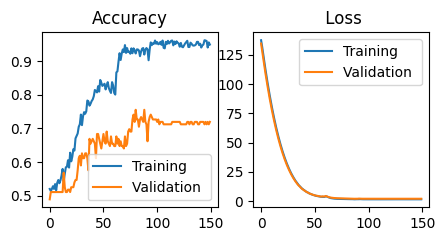

len(shap_values[0])  139
shap_values[0].shape  (139, 221, 1)
len(shap_values[1])  139
shap_values[1].shape  (139, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7802402651201326
----------------------T------------------- 45.13251543045044



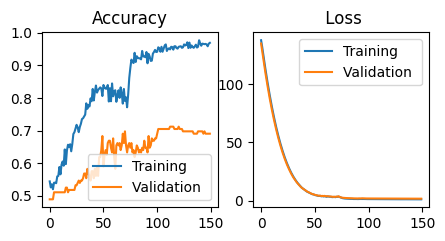

len(shap_values[0])  139
shap_values[0].shape  (139, 221, 1)
len(shap_values[1])  139
shap_values[1].shape  (139, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7493786246893124
----------------------T------------------- 45.719950437545776



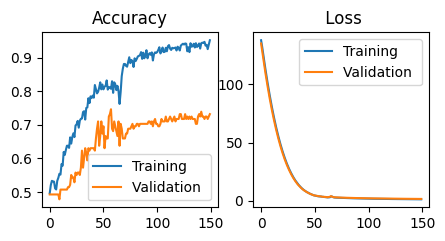

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 4ms/step
---------------------AUC------------------ 0.8403361344537815
----------------------T------------------- 46.00537371635437



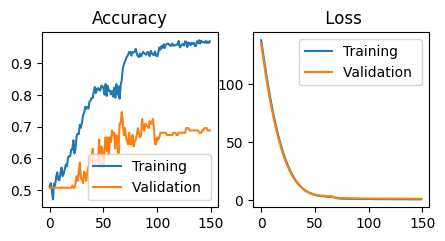

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7852941176470588
----------------------T------------------- 43.82424712181091



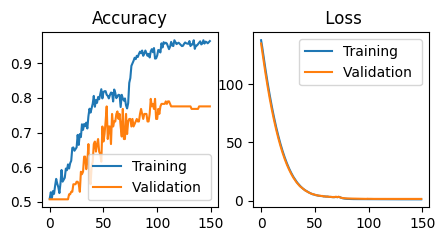

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.8626050420168068
----------------------T------------------- 46.332911252975464



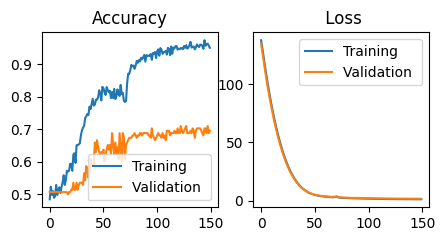

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 2ms/step
---------------------AUC------------------ 0.767436974789916
----------------------T------------------- 45.698625326156616



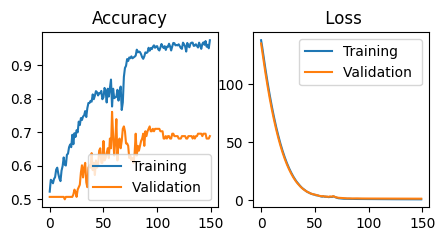

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7455882352941177
----------------------T------------------- 45.62447762489319



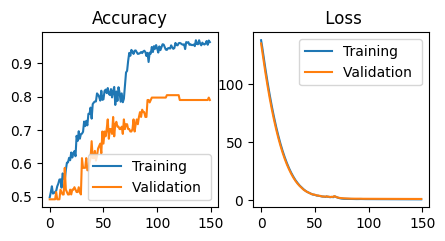

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.8516806722689075
----------------------T------------------- 47.18180537223816



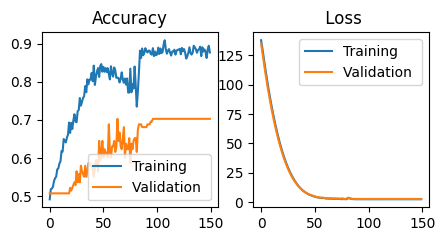

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 4ms/step
---------------------AUC------------------ 0.7609243697478991
----------------------T------------------- 44.57989001274109



In [12]:
cv = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=rs_) # Set random state

for train_index, test_index in cv.split(DF_normalized.iloc[:, 1:], DF_normalized.iloc[:, 0]):
    start = time.time()
    df_train, df_test = DF_normalized.iloc[train_index, :], DF_normalized.iloc[test_index, :]

    X_train_struct, X_test_struct = df_train.iloc[:, 1:222], df_test.iloc[:, 1:222]
    X_train_funct, X_test_funct = df_train.iloc[:, 222:], df_test.iloc[:, 222:]
    y_train, y_test = df_train.iloc[:, 0], df_test.iloc[:, 0]

        #load the model
    clear_session()
    mod_1 = structural_model
    mod_2 = functional_model
    model_joint = joint_model(mod_1(), mod_2())

        # Compile the model
    model_joint.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

        # Fit data to model
    history = model_joint.fit((X_train_struct, X_train_funct), y_train,
                          batch_size=64,
                          epochs=150,
                          verbose=0,
                          validation_data = ((X_test_struct, X_test_funct), y_test),
                          callbacks=[reduce_on_plateau]
                          )
    
    #Train and validation accuracy
    plt.figure(figsize=(5, 5))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training ')
    plt.plot(history.history['val_accuracy'], label='Validation ')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    #Train and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training ')
    plt.plot(history.history['val_loss'], label='Validation ')
    plt.legend(loc='upper right')
    plt.title(' Loss')
    plt.show()
    
    # prepare for SHAP
    X_train_struct_SHAP = X_train_struct.to_numpy()
    X_test_struct_SHAP = X_test_struct.to_numpy()
    X_train_funct_SHAP = X_train_funct.to_numpy()
    X_test_funct_SHAP = X_test_funct.to_numpy()

    # Use SHAP to explain predictions
    explainer = shap.GradientExplainer(model_joint, [X_train_struct_SHAP, X_train_funct_SHAP])
    shap_values = explainer.shap_values([X_test_struct_SHAP, X_test_funct_SHAP])
    
    #  SHAP information per fold
    shap_values_per_cv_s.append(shap_values[0]) #  221 features, append an array with dims 138/139,  221, 1
    shap_values_per_cv_f.append(shap_values[1]) # 5253 features, append an array with dims 138/139, 5253, 1

    print("len(shap_values[0]) ",len(shap_values[0]))
    print("shap_values[0].shape ",shap_values[0].shape)
    print("len(shap_values[1]) ",len(shap_values[1]))
    print("shap_values[1].shape ",shap_values[1].shape)

    #print(X_test_struct.shape)
        ###########################################################
    _, val_acc = model_joint.evaluate((X_test_struct, X_test_funct), y_test, verbose=0)
    acc.append(val_acc)

        #Compute Receiver operating characteristic (ROC)
    i=0
    preds = model_joint.predict((X_test_struct, X_test_funct), verbose=1)
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    tprs.append(interp_tpr)
    AUC.append(roc_auc)
    i += 1
    print('---------------------AUC------------------', roc_auc)
    end = time.time()
    print('----------------------T-------------------', end - start)
    print("")

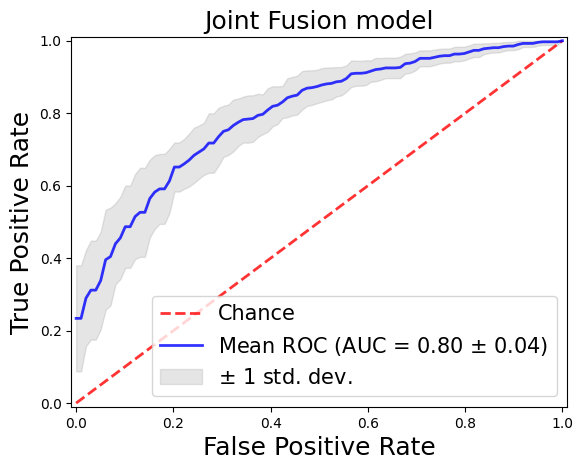

In [13]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(interp_fpr, mean_tpr)
std_auc = np.std(AUC)
plt.plot(interp_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Joint Fusion model',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [14]:
# == Provide average scores ==
print(len(AUC))
print(f'AUC:{np.mean(AUC):.4f} (+- {np.std(AUC):.4f})')
print(f'accuracy: {np.mean(acc):.4f} (+- {np.std(acc):.4f})')

10
AUC:0.7982 (+- 0.0429)
accuracy: 0.7224 (+- 0.0350)


In [15]:
# Establish lists to keep average Shap values
average_shap_values_s = []
average_shap_values_f = []

for i in range(0, len(AUC)):
    df_per_obs = shap_values_per_cv_s[i].copy()
    df_per_obs = np.absolute(df_per_obs)
    average_shap_values_s.append(df_per_obs.mean(axis=0))

    df_per_f = shap_values_per_cv_f[i].copy()
    df_per_f = np.absolute(df_per_f)
    average_shap_values_f.append(df_per_f.mean(axis=0))

fold_s = np.transpose(np.array(average_shap_values_s)[...,0])
fold_f = np.transpose(np.array(average_shap_values_f)[...,0])

# SHAP values Joint model: NORMALIZATION SHAP VALUES 

Here, we normalize SHAP values separatly for structural and functional model. The SHAP values for each cross-validation fold are processed as follows:

1) They are transformed into a DataFrame
2) Then the SHAP values are weighted and expressed in percentage, taking into account the fact that the number of functional features is higher with respect do the structural one. Without this weight the SHAP values of structural features would be very much higher with respect to the functional one.
3) Finally, the SHAP values are concatenated and sorted according to their values.

In [16]:
fold_s = pd.DataFrame.from_dict(fold_s)
fold_f = pd.DataFrame.from_dict(fold_f)

In [17]:
# Definition of the weighting factor
s = 221/(2*(221 + 5253))
f = 5253/(2*(221 + 5253))

In [18]:
fold_s_n = (fold_s/fold_s.sum(axis=0))*s*100
plot = fold_s_n.mean(axis=1).values
struct_SHAP = pd.DataFrame({"SHAP_values": plot}, index = DF_normalized.iloc[:, 1:222].columns )
struct_SHAP['std']=fold_s_n.std(axis=1).values
struct_SHAP = struct_SHAP.sort_values(by="SHAP_values", ascending=False)
struct_SHAP

,SHAP_values,std
lh_superiortemporal_ThickAvg,0.050065,0.013068
rh_pericalcarine_GrayVol,0.047193,0.014070
lh_medialorbitofrontal_ThickAvg,0.039562,0.022645
lh_entorhinal_GrayVol,0.036604,0.009478
Left-VentralDC_Volume_mm3,0.034096,0.012039
...,...,...
TotalGrayVol,0.002024,0.001519
lhCortexVol,0.001921,0.001287
lh_lateralorbitofrontal_ThickAvg,0.001643,0.001051
rhCortexVol,0.001629,0.001466


In [19]:
norm = fold_f.sum(axis=0)
fold_f_n = (fold_f/fold_f.sum(axis=0))*f*100
plot_f = fold_f_n.mean(axis=1).values
funct_SHAP = pd.DataFrame({"SHAP_values" : plot_f}, index = DF_normalized.iloc[:, 222:].columns )
funct_SHAP['std']=fold_f_n.std(axis=1).values
funct_SHAP = funct_SHAP.sort_values(by="SHAP_values", ascending=False)
funct_SHAP

,SHAP_values,std
731,0.078131,0.025644
2933,0.076033,0.028807
1855,0.074325,0.038638
1611,0.072200,0.028864
3228,0.065565,0.023516
...,...,...
4282,0.001814,0.001013
1928,0.001775,0.000725
1533,0.001753,0.001202
5009,0.001574,0.002003


In [20]:
all_m_s =  pd.concat([struct_SHAP,funct_SHAP])
all_for_SHAP = all_m_s.sort_values(by="SHAP_values", ascending=False)
all_for_SHAP

,SHAP_values,std
731,0.078131,0.025644
2933,0.076033,0.028807
1855,0.074325,0.038638
1611,0.072200,0.028864
3228,0.065565,0.023516
...,...,...
lh_lateralorbitofrontal_ThickAvg,0.001643,0.001051
rhCortexVol,0.001629,0.001466
5009,0.001574,0.002003
525,0.001301,0.000679


As a check, the sum of all the SHAP values must be equal to 100%

In [21]:
all_for_SHAP.sum(axis='rows')

SHAP_values    50.000000
std            43.627346
dtype: float64

At this point, we have a dataframe that contains all the features from the most important to the less important. Now we select the scores above the 99th percentile of importance features selected by SHAP.

## Selection of 99th percentile of features importance

Since we cannot plot the feature importance for all the features, we select only the ones with an importance over the 99% of the importance values in the dataset. We will define two variables: ine with all the sorted feature importance and one with only the functional features. This will help in the visualization of the functional features.

In [22]:
th99 = all_for_SHAP.iloc[:, 0].quantile(0.99)
th99

0.03651702057425823

In [23]:
ALL_SHAP_99 = all_for_SHAP[all_for_SHAP["SHAP_values"] >= th99]["SHAP_values"]
funct_SHAP_99 = funct_SHAP[funct_SHAP["SHAP_values"] >= th99]["SHAP_values"]

In [24]:
important_funct_features_SHAP = funct_SHAP_99.index.astype('int').tolist()

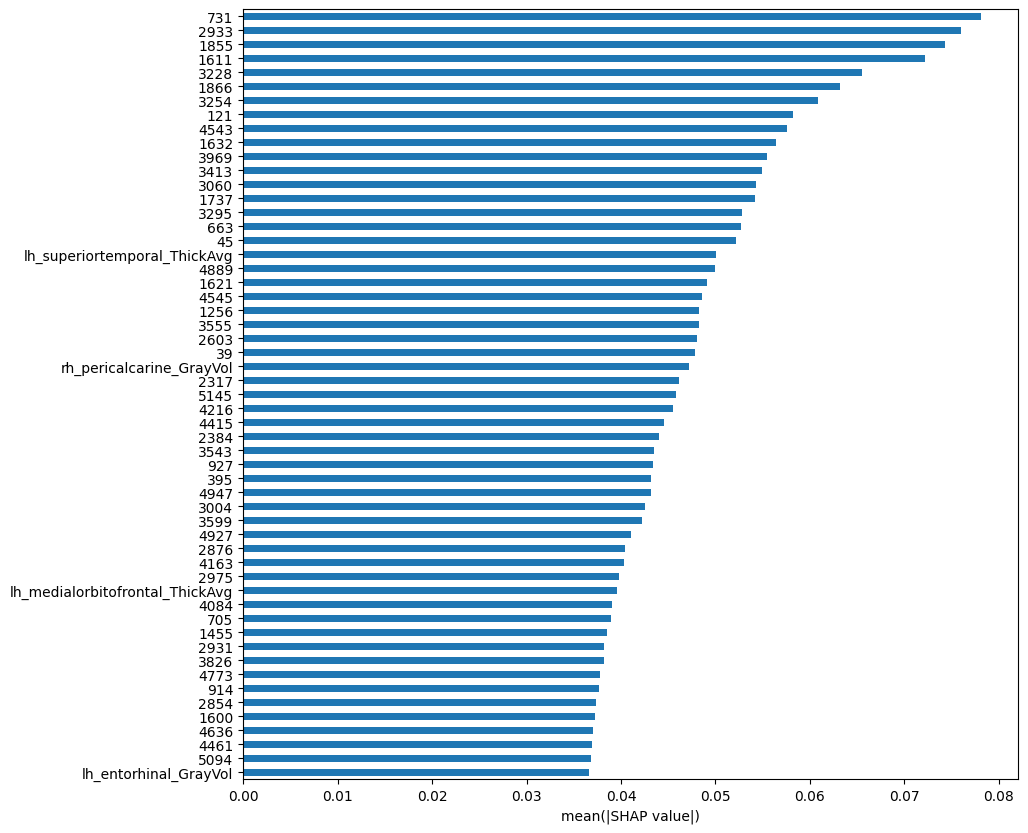

In [25]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = all_for_SHAP[all_for_SHAP["SHAP_values"] >= th99]["SHAP_values"].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value|)")
plt.show()

## Cohen d coeff

The Cohen's *d* coefficient is a statistical measure used to quantify the *effect size* between two groups, indicating the standardized difference between their means. It is commonly used in psychology, social sciences, and other fields to assess the difference between two sample groups.

### Formula

The formula for Cohen’s *d* is:
$$
d = \frac{\bar{X}_1 - \bar{X}_2}{s}
$$
where: $\bar{X}_1$ and $\bar{X}_2$ are the means of the two groups. $s$ is the pooled standard deviation of the two groups, calculated as:
$$
s = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}}
$$
where: $n_1$ and $n_2$ are the sample sizes of the two groups. $s_1$ and $s_2$ are the standard deviations of the two groups.

### Interpretation
Cohen's *d* provides a way to interpret the magnitude of the difference, regardless of the scale of the data, making it easier to compare across studies. Common interpretations are:
- **0.2** - Small effect size
- **0.5** - Medium effect size
- **0.8** or higher - Large effect size

These are general guidelines, and the interpretation can vary by field. Cohen's *d* is particularly helpful because it puts the difference in a standardized context, allowing researchers to understand the size of an effect without being influenced by sample size alone.

In [26]:
def Cohen_d(g1, g2, f):
    """Function to compute the Cohen's d Coefficient.

    g1: infered results by predictor 1
    g2: infered results by predictor 2
    f:  predicted class ?

    it returns the 'd' value of agreement
    """
    n1 = len(g1)                   # number of data in g1
    n2 = len(g2)                   # number of data in g2
    N = n1 + n2                    # total number of data
    Scores1 = g1[f].dropna()       # remove nan results
    Scores2 = g2[f].dropna()
    var1 = Scores1.var()           # compute the variance over the dataset
    var2 = Scores2.var()
    mean1 = Scores1.mean()         # compute the mean result
    mean2 = Scores2.mean()
    sp = (((n1 - 1)*var1 + (n2 - 1)*var2) / (N - 2))**0.5
    d = (mean1 - mean2) / sp
    return d

In [27]:
controls = DF_normalized[DF_normalized.DX_GROUP==0]
ASD =  DF_normalized[DF_normalized.DX_GROUP==1]
list_f = all_m_s.iloc[:].index.tolist()
score_df = []
for item in list_f:
    score =  Cohen_d(ASD, controls, item)
    score_df.append(score)
    #print(item, score)
all_m_s['cohen']=score_df

In [28]:
cohen_all = all_m_s.drop(['SHAP_values','std'], axis = 'columns')
cohen_funct = cohen_all[221:]
cohen_sorted = cohen_funct.sort_values(by="cohen", ascending=False)

In [29]:
important_funct_features_COHEN_ASD = cohen_sorted[:20].index.astype('int').tolist()
important_funct_features_COHEN_TD = cohen_sorted[5233:].index.astype('int').tolist()

## Find region's coord in HO

Since functional features are not easy to be associated with the real meaning, i. e. it is not easy to understand the parts of the brain that are used to compute that feature, here we go back from the functional features to some images that helps in understanding their meaning.

In [30]:
from nilearn import datasets, plotting

functional_names = pd.read_csv(path_to_data + 'functional_features.csv')
functional_names = functional_names.set_index('F')

Here, we reduce the nyumber of features to match the available color maps.

In [31]:
reduction_features = important_funct_features_SHAP[:13]
perc_95 = functional_names.loc[reduction_features]
connection_list = functional_names.loc[reduction_features]
l1 = connection_list['r1'].to_list()
l2 = connection_list['r2'].to_list()
l = l1 + l2
sam_list = list(set(l)) # the redundant feature names are deleted
region_c = []
label_c = []

In [32]:
#load HO atlas
atlas_ho = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')  #sub-maxprob-thr50-2mm - cortl-maxprob-thr25-2mm
atlas_file = atlas_ho.maps
labels = atlas_ho.labels[1:]
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)

In [33]:
# Load labels for each atlas region

print(len(labels))

atlas_ho = datasets.fetch_atlas_harvard_oxford('cortl-maxprob-thr25-2mm')
atlas_file = atlas_ho.maps
# Load labels for each atlas region
atlas_labels = atlas_ho.labels[1:]
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)
print(len(labels))

for i, e in enumerate(atlas_labels):
  for j, n in enumerate(sam_list):
    if e == n:
      region_c.append(coordinates[i])
      label_c.append(e)

len(label_c)

21
21


18

## PLOT connectoma

In [34]:
from matplotlib import colormaps as cm
from matplotlib.lines import Line2D

for i in range(0, len(label_c)):
    print("i, region_c[i],label_c[i]")
    print(i, region_c[i],label_c[i])

index_1 = []
for j, n in enumerate(l1):
    for i, e in enumerate(label_c):
        if n == e:
            index_1.append(i)

index_2=[]
for j, n in enumerate(l2):
    for i, e in enumerate(label_c):
        if n == e:
            index_2.append(i)

i, region_c[i],label_c[i]
0 [-24.95890023  52.9957483    7.53259637] Left Frontal Pole
i, region_c[i],label_c[i]
1 [14.69800333 18.86855241 57.12978369] Right Superior Frontal Gyrus
i, region_c[i],label_c[i]
2 [52.31048387 28.          7.76209677] Right Inferior Frontal Gyrus, pars triangularis
i, region_c[i],label_c[i]
3 [-40.62723404  11.14382979 -29.70297872] Left Temporal Pole
i, region_c[i],label_c[i]
4 [ 40.70055061  13.06903854 -29.83396866] Right Temporal Pole
i, region_c[i],label_c[i]
5 [ 61.49482072 -22.39043825 -12.78087649] Right Middle Temporal Gyrus, posterior division
i, region_c[i],label_c[i]
6 [-57.84290739 -53.07151231   0.83470106] Left Middle Temporal Gyrus, temporooccipital part
i, region_c[i],label_c[i]
7 [ 58.40660295 -49.15899218   1.53779322] Right Middle Temporal Gyrus, temporooccipital part
i, region_c[i],label_c[i]
8 [-51.93678161 -53.47701149 -16.59770115] Left Inferior Temporal Gyrus, temporooccipital part
i, region_c[i],label_c[i]
9 [ 37.99938386 -26.1712

In [35]:
mat =np.zeros((len(region_c), len(region_c)))

for index, (value1, value2) in enumerate(zip(index_1, index_2)):
    #print(index, value1 , value2)
    mat[value1][value2] = 1
mat

mat = mat + mat.T
coordinates = np.array(region_c)  # 3D coordinates of parcels

color_dict = {}
cmap = cm.get_cmap('tab20')

for rsn, c in zip(label_c, cmap.colors):
    color_dict[rsn] = tuple(c)

In [36]:
node_color = []
for nw in label_c:
    node_color.append(color_dict[nw])

coords = coordinates
N = len(coords)

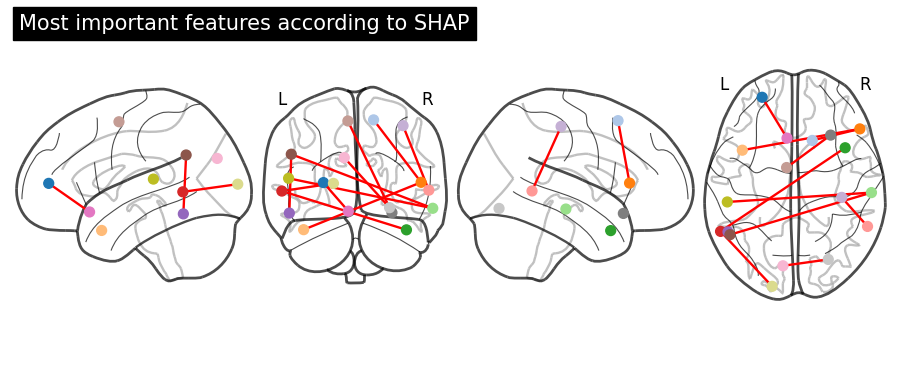

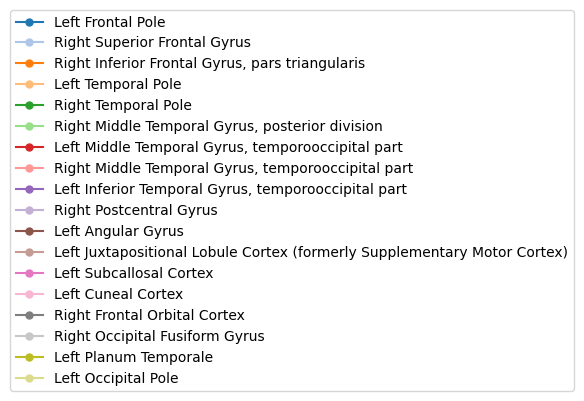

In [37]:
plotting.plot_connectome(mat,
                         coords,
                         title='Most important features according to SHAP',
                         node_color=node_color,
                          display_mode="lyrz",
                         edge_kwargs = {"linewidth":1.7, "color": 'red'})
legend_elements = []
for k,v in color_dict.items():
    legend_elements.append(Line2D([0], [0], marker='o', color=v, label=k,
                          markerfacecolor=v, markersize=5))
# Create the figure
fig, ax = plt.subplots()
ax.axis("off")
ax.legend(handles=legend_elements, loc='center')

## Connettoma plot according to Cohen Values

### ASD > TD

In [38]:
reduction_features = important_funct_features_COHEN_ASD
perc_95 = functional_names.loc[reduction_features]
connection_list = functional_names.loc[reduction_features]
l1 = connection_list['r1'].to_list()
l2 = connection_list['r2'].to_list()
l = l1 + l2
sam_list = list(set(l)) # the redundant feature names are deleted
region_c = []
label_c = []

In [39]:
atlas_ho = datasets.fetch_atlas_harvard_oxford('cortl-maxprob-thr25-2mm')
atlas_file = atlas_ho.maps
# Load labels for each atlas region
atlas_labels = atlas_ho.labels[1:]
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)
print(len(labels))

for i, e in enumerate(atlas_labels):
  for j, n in enumerate(sam_list):
    if e == n:
      region_c.append(coordinates[i])
      label_c.append(e)

len(label_c)
for i in range(0, len(label_c)):
    print("i, region_c[i],label_c[i]")
    print(i, region_c[i],label_c[i])

index_1 = []
for j, n in enumerate(l1):
    for i, e in enumerate(label_c):
        if n == e:
            index_1.append(i)

index_2=[]
for j, n in enumerate(l2):
    for i, e in enumerate(label_c):
        if n == e:
            index_2.append(i)
mat =np.zeros((len(region_c), len(region_c)))

for index, (value1, value2) in enumerate(zip(index_1, index_2)):
    #print(index, value1 , value2)
    mat[value1][value2] = 1
mat

mat = mat + mat.T
coordinates = np.array(region_c)  # 3D coordinates of parcels

color_dict = {}
cmap = cm.get_cmap('tab20')

for rsn, c in zip(label_c, cmap.colors):
    color_dict[rsn] = tuple(c)
node_color = []
for nw in label_c:
    node_color.append(color_dict[nw])

coords = coordinates
N = len(coords)

21
i, region_c[i],label_c[i]
0 [-60.64538198 -27.36374002   2.36488027] Left Superior Temporal Gyrus, posterior division
i, region_c[i],label_c[i]
1 [ 60.30849948 -23.29275971   1.57607555] Right Superior Temporal Gyrus, posterior division
i, region_c[i],label_c[i]
2 [-57.61434978  -4.04484305 -22.35426009] Left Middle Temporal Gyrus, anterior division
i, region_c[i],label_c[i]
3 [-57.84290739 -53.07151231   0.83470106] Left Middle Temporal Gyrus, temporooccipital part
i, region_c[i],label_c[i]
4 [ 58.40660295 -49.15899218   1.53779322] Right Middle Temporal Gyrus, temporooccipital part
i, region_c[i],label_c[i]
5 [-38.54771098 -27.74517375  51.854385  ] Left Postcentral Gyrus
i, region_c[i],label_c[i]
6 [ 37.99938386 -26.17128774  52.55514479] Right Postcentral Gyrus
i, region_c[i],label_c[i]
7 [ 58.54522613 -27.11055276  37.91708543] Right Supramarginal Gyrus, anterior division
i, region_c[i],label_c[i]
8 [ 55.28914664 -40.46561723  33.82435791] Right Supramarginal Gyrus, posterior d

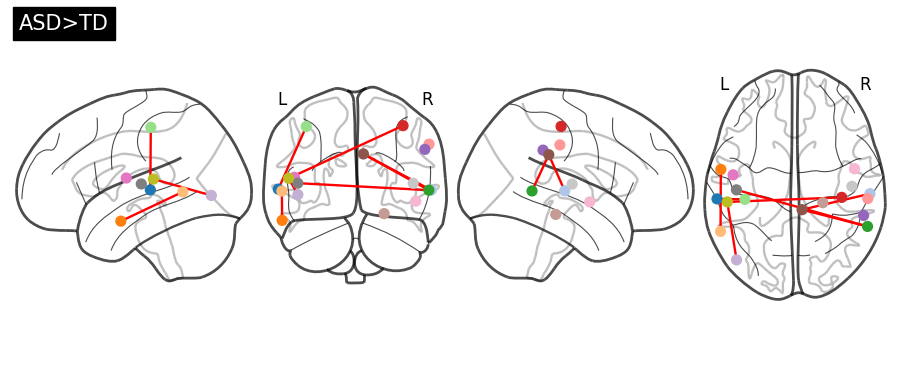

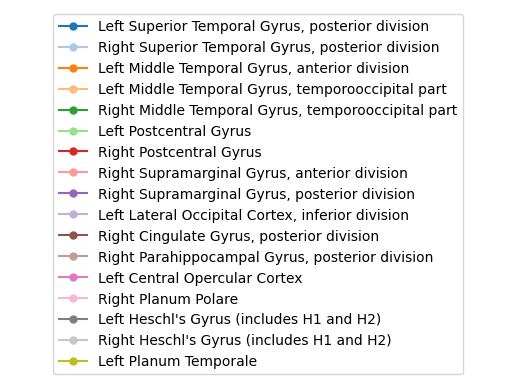

In [40]:
plotting.plot_connectome(mat,
                         coords,
                         title='ASD>TD',
                         node_color=node_color,
                          display_mode="lyrz",
                         edge_kwargs = {"linewidth":1.7, "color": 'red'})
legend_elements = []
for k,v in color_dict.items():
    legend_elements.append(Line2D([0], [0], marker='o', color=v, label=k,
                          markerfacecolor=v, markersize=5))
# Create the figure
fig, ax = plt.subplots()
ax.axis("off")
ax.legend(handles=legend_elements, loc='center')

### TD>ASD

In [41]:
reduction_features = important_funct_features_COHEN_TD[:16]
perc_95 = functional_names.loc[reduction_features]
connection_list = functional_names.loc[reduction_features]
l1 = connection_list['r1'].to_list()
l2 = connection_list['r2'].to_list()
l = l1 + l2
sam_list = list(set(l)) # the redundant feature names are deleted
region_c = []
label_c = []

In [42]:
atlas_ho = datasets.fetch_atlas_harvard_oxford('cortl-maxprob-thr25-2mm')
atlas_file = atlas_ho.maps
# Load labels for each atlas region
atlas_labels = atlas_ho.labels[1:]
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)

for i, e in enumerate(atlas_labels):
  for j, n in enumerate(sam_list):
    if e == n:
      region_c.append(coordinates[i])
      label_c.append(e)

len(label_c)
for i in range(0, len(label_c)):
    print("i, region_c[i],label_c[i]")
    print(i, region_c[i],label_c[i])

index_1 = []
for j, n in enumerate(l1):
    for i, e in enumerate(label_c):
        if n == e:
            index_1.append(i)

index_2=[]
for j, n in enumerate(l2):
    for i, e in enumerate(label_c):
        if n == e:
            index_2.append(i)
mat =np.zeros((len(region_c), len(region_c)))

for index, (value1, value2) in enumerate(zip(index_1, index_2)):
    #print(index, value1 , value2)
    mat[value1][value2] = 1
mat

mat = mat + mat.T
coordinates = np.array(region_c)  # 3D coordinates of parcels

color_dict = {}
cmap = cm.get_cmap('tab20')

for rsn, c in zip(label_c, cmap.colors):
    color_dict[rsn] = tuple(c)
node_color = []
for nw in label_c:
    node_color.append(color_dict[nw])

coords = coordinates
N = len(coords)

i, region_c[i],label_c[i]
0 [-49.99341021  28.57001647   8.80395387] Left Inferior Frontal Gyrus, pars triangularis
i, region_c[i],label_c[i]
1 [-60.64538198 -27.36374002   2.36488027] Left Superior Temporal Gyrus, posterior division
i, region_c[i],label_c[i]
2 [-57.61434978  -4.04484305 -22.35426009] Left Middle Temporal Gyrus, anterior division
i, region_c[i],label_c[i]
3 [ 57.90547264  -1.30845771 -24.70149254] Right Middle Temporal Gyrus, anterior division
i, region_c[i],label_c[i]
4 [ 61.49482072 -22.39043825 -12.78087649] Right Middle Temporal Gyrus, posterior division
i, region_c[i],label_c[i]
5 [-38.54771098 -27.74517375  51.854385  ] Left Postcentral Gyrus
i, region_c[i],label_c[i]
6 [-29.38026225 -49.55279503  57.65217391] Left Superior Parietal Lobule
i, region_c[i],label_c[i]
7 [ 29.29266621 -47.77107608  59.07607951] Right Superior Parietal Lobule
i, region_c[i],label_c[i]
8 [ 58.54522613 -27.11055276  37.91708543] Right Supramarginal Gyrus, anterior division
i, region_c[i

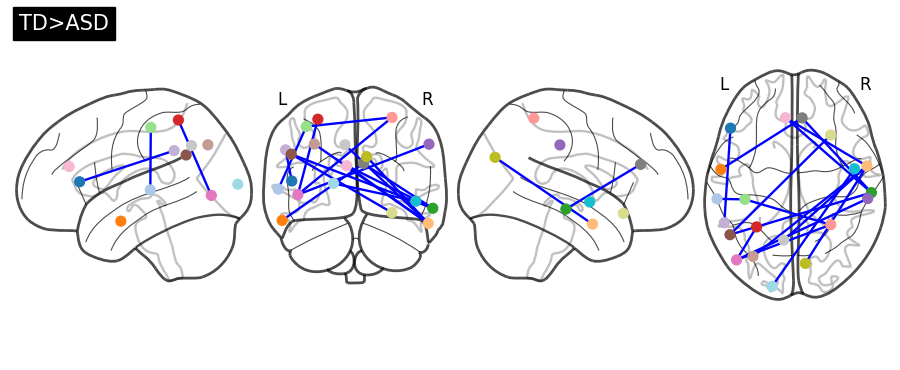

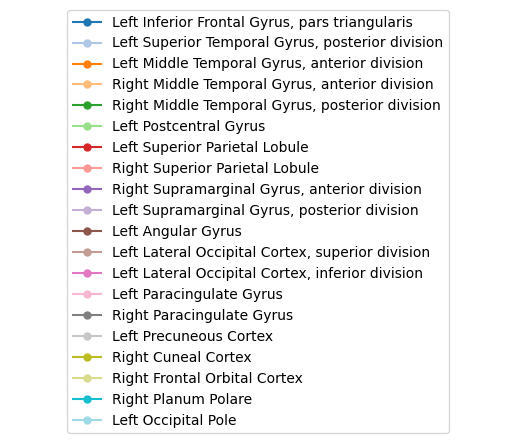

In [43]:
plotting.plot_connectome(mat,
                         coords,
                         title='TD>ASD',
                         node_color=node_color,
                          display_mode="lyrz",
                         edge_kwargs = {"linewidth":1.7, "color": 'blue'})
legend_elements = []
for k,v in color_dict.items():
    legend_elements.append(Line2D([0], [0], marker='o', color=v, label=k,
                          markerfacecolor=v, markersize=5))
# Create the figure
fig, ax = plt.subplots()
ax.axis("off")
ax.legend(handles=legend_elements, loc='center')